In [ ]:
import os, json, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from datetime import datetime

BASE = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))
DATA_DIR = "/Users/andrewrodriguez/Desktop/compsci1050/privacy_policies/policy_texts"
FIG_DIR = "/Users/andrewrodriguez/Desktop/compsci1050/privacy_policies/figures"
REPORTS_DIR = "/Users/andrewrodriguez/Desktop/compsci1050/privacy_policies/reports"

from helpers import (
    analyze_text, load_local_texts, fetch_policy_text, polite_sleep,
    get_wayback_snapshots, fetch_wayback_content, html_to_text, domain_from_url
)

print('BASE:', BASE)
print('DATA_DIR:', DATA_DIR)
print('FIG_DIR:', FIG_DIR)
print('REPORTS_DIR:', REPORTS_DIR)

BASE: /Users/andrewrodriguez/Desktop/compsci1050
DATA_DIR: /Users/andrewrodriguez/Desktop/compsci1050/privacy_policies/policy_texts
FIG_DIR: /Users/andrewrodriguez/Desktop/compsci1050/privacy_policies/figures
REPORTS_DIR: /Users/andrewrodriguez/Desktop/compsci1050/privacy_policies/reports


In [9]:
texts = {}
if os.path.isdir(DATA_DIR):
    texts.update(load_local_texts(DATA_DIR))
print(f'Loaded {len(texts)} local files')

Loaded 7 local files


In [ ]:

rows = []
for name, text in texts.items():
    rows.append(analyze_text(name, text))
df = pd.DataFrame(rows).set_index('name').sort_index()
display(df.head())
df.to_csv(os.path.join(REPORTS_DIR, 'metrics.csv'), index=True)
print('Saved metrics to reports/metrics.csv')

,n_chars,n_words,n_sents,flesch_reading_ease,flesch_kincaid_grade,gunning_fog,smog_index,dale_chall,coleman_liau,ari,avg_sentence_length,ttr,yule_k,entropy,avg_zipf,rare_frac,legalese_frac
name,,,,,,,,,,,,,,,,,
amazon,27478,4164,160,25.075821,16.227089,19.747176,17.489301,11.730236,14.539193,17.644276,26.025000,0.219292,93.476508,8.219079,5.607517,0.009266,0.004277
apple,29703,4637,200,29.172227,14.950188,17.874388,16.162427,11.225745,13.362993,15.207038,23.185000,0.202908,99.283820,8.113057,5.679806,0.009692,0.009482
google,64446,10254,401,37.594990,14.368148,17.472431,15.655500,11.583315,12.816228,15.852249,25.571072,0.139813,97.857111,8.273859,5.675013,0.012535,0.004821
meta,35133,5546,149,23.316218,19.254035,21.596128,17.712588,11.769075,13.470429,21.978787,37.221477,0.129702,130.592344,7.616436,5.770186,0.007452,0.004968
palantir,59335,8974,300,18.604502,18.095678,21.267763,18.613347,12.332505,14.800891,19.869173,29.913333,0.141534,102.235467,8.185523,5.646391,0.023589,0.011795


Saved metrics to reports/metrics.csv


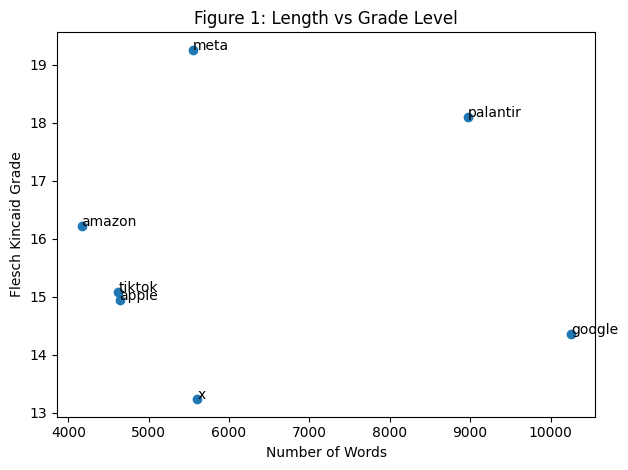

In [ ]:

plt.figure()
plt.scatter(df['n_words'], df['flesch_kincaid_grade'])
for i, name in enumerate(df.index):
    plt.annotate(name, (df['n_words'].iloc[i], df['flesch_kincaid_grade'].iloc[i]))
plt.xlabel('Number of Words')
plt.ylabel('Flesch Kincaid Grade')
plt.title('Figure 1: Length vs Grade Level')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'length_vs_grade.png'), dpi=200)
plt.show()

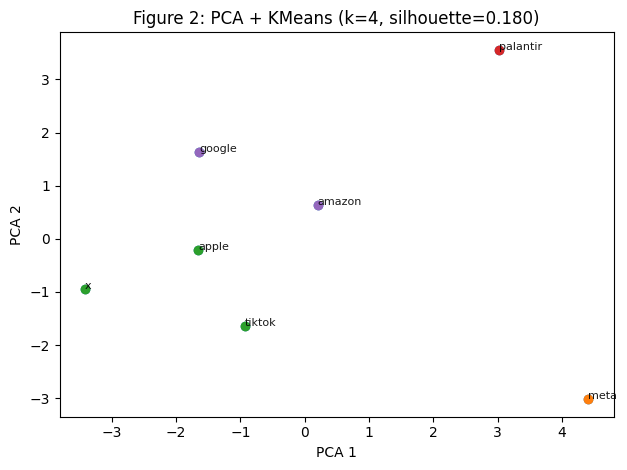

,cluster_label,nearest_same_type,dist_same_type,nearest_overall,dist_overall
name,,,,,
meta,0,None,NaN,tiktok,5.5123
apple,1,tiktok,1.5984,tiktok,1.5984
tiktok,1,apple,1.5984,apple,1.5984
x,1,apple,1.9064,apple,1.9064
palantir,2,None,NaN,amazon,4.0622
amazon,3,google,2.0920,apple,2.0433
google,3,amazon,2.0920,apple,1.8430



Nearest-neighbor summary by type (prototype within each cluster):


,cluster_label,prototype,prototype_nearest_same,distance
0,0,meta,None,NaN
1,1,apple,tiktok,1.5984
2,2,palantir,None,NaN
3,3,google,amazon,2.0920


In [ ]:
features = ['n_words','n_sents','avg_sentence_length','flesch_kincaid_grade',
            'gunning_fog','smog_index','dale_chall','coleman_liau','ari',
            'ttr','yule_k','entropy','avg_zipf','rare_frac','legalese_frac']

missing = [c for c in features if c not in df.columns]
if missing:
    print('Missing features (will be dropped):', missing)
    features = [c for c in features if c in df.columns]

X = df[features].replace([np.inf,-np.inf], np.nan).fillna(df[features].median())
scaler = StandardScaler()
Z = scaler.fit_transform(X)    

pca = PCA(n_components=2, random_state=0)
P = pca.fit_transform(Z)       


k_fixed = 4
km = KMeans(n_clusters=k_fixed, random_state=0, n_init='auto')
labels = km.fit_predict(P)

try:
    best_sil = silhouette_score(P, labels)
except Exception:
    best_sil = float('nan')

# --- Plot ---
plt.figure()
plt.scatter(P[:,0], P[:,1])

for c in sorted(np.unique(labels)):
    idx = np.where(labels == c)[0]
    plt.scatter(P[idx, 0], P[idx, 1], label=f'Cluster {c}')
    # annotate each point
    for i in idx:
        plt.annotate(df.index[i], (P[i, 0], P[i, 1]), fontsize=8, alpha=0.9)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title(f'Figure 2: PCA + KMeans (k=4, silhouette={best_sil:.3f})')
plt.tight_layout()
os.makedirs(FIG_DIR, exist_ok=True)
plt.savefig(os.path.join(FIG_DIR, 'pca_kmeans.png'), dpi=200)
plt.show()
 
df['cluster_k'] = k_fixed
df['cluster_label'] = labels


diff = P[:, None, :] - P[None, :, :]
D = np.sqrt(np.sum(diff**2, axis=2))  
np.fill_diagonal(D, np.inf)  

names = list(df.index)

nearest_any_idx = np.argmin(D, axis=1)
nearest_any = [
    (names[i], names[nearest_any_idx[i]], float(D[i, nearest_any_idx[i]]))
    for i in range(len(names))
]

nearest_same = []
for i in range(len(names)):
    same_mask = (labels == labels[i])
    same_mask[i] = False 
    if not np.any(same_mask):
        nearest_same.append((names[i], None, np.nan))
        continue

    d_row = D[i].copy()
    d_row[~same_mask] = np.inf
    j = int(np.argmin(d_row))
    nearest_same.append((names[i], names[j], float(d_row[j])))

rows = []
for (name, any_nbr, any_d), (_, same_nbr, same_d) in zip(nearest_any, nearest_same):
    rows.append({
        "name": name,
        "cluster_label": int(df.loc[name, "cluster_label"]),
        "nearest_same_type": same_nbr,
        "dist_same_type": round(same_d, 4) if same_nbr is not None else None,
        "nearest_overall": any_nbr,
        "dist_overall": round(any_d, 4),
    })
nn_df = pd.DataFrame(rows).set_index("name").sort_values(["cluster_label", "name"])
display(nn_df)

os.makedirs(REPORTS_DIR, exist_ok=True)
nn_df.to_csv(os.path.join(REPORTS_DIR, "nearest_neighbors_k4_features.csv"))

summary_rows = []
for c in sorted(set(labels)):
    idxs = np.where(labels == c)[0]
    centroid = km.cluster_centers_[c]
    d_to_center = np.sqrt(np.sum((P[idxs] - centroid)**2, axis=1))
    proto_local = int(np.argmin(d_to_center))
    i = int(idxs[proto_local])        
    same_mask = (labels == c)
    same_mask[i] = False
    if np.any(same_mask):
        d_row = D[i].copy()
        d_row[~same_mask] = np.inf
        j = int(np.argmin(d_row))
        proto_nbr = names[j]
        proto_d   = float(d_row[j])
    else:
        proto_nbr, proto_d = None, np.nan

    summary_rows.append({
        "cluster_label": int(c),
        "prototype": names[i],
        "prototype_nearest_same": proto_nbr,
        "distance": round(proto_d, 4) if proto_nbr is not None else None
    })

cluster_summary = pd.DataFrame(summary_rows).sort_values("cluster_label")
print("\nNearest-neighbor summary by type (prototype within each cluster):")
display(cluster_summary)

<Figure size 1000x600 with 0 Axes>

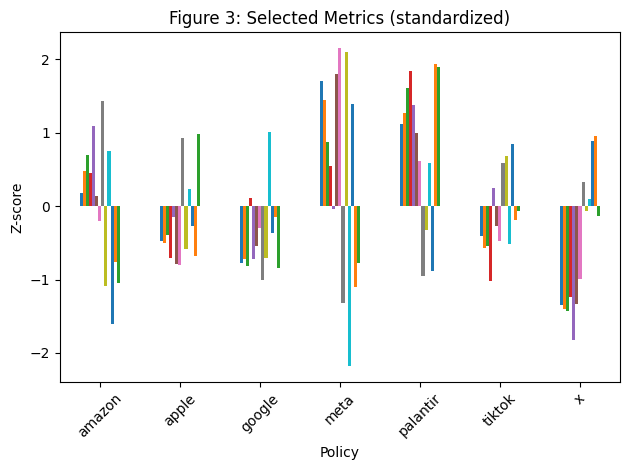

In [ ]:
cols = ['flesch_kincaid_grade','gunning_fog','smog_index','dale_chall','coleman_liau','ari',
        'avg_sentence_length','ttr','yule_k','entropy','avg_zipf','rare_frac','legalese_frac']
cols = [c for c in cols if c in df.columns]

M = df[cols].replace([np.inf,-np.inf], np.nan).fillna(df[cols].median())
M = (M - M.mean())/M.std(ddof=0)

plt.figure(figsize=(10,6))
M.plot(kind='bar', rot=45, legend=False)
plt.xlabel('Policy')
plt.ylabel('Z-score')
plt.title('Figure 3: Selected Metrics (standardized)')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'metric_bars.png'), dpi=200)
plt.show()

In [ ]:
import os, re
from datetime import datetime
import pandas as pd
HIST_DIR = "/Users/andrewrodriguez/Desktop/compsci1050/privacy_policies/google_historical"


date_pat = re.compile(r"(?P<mm>\d{1,2})[_-](?P<dd>\d{1,2})[_-](?P<yyyy>\d{4})\.txt$", re.IGNORECASE)

hist_rows = []
for fn in sorted(os.listdir(HIST_DIR)):
    if not fn.lower().endswith(".txt"):
        continue
    m = date_pat.search(fn)
    if not m:
        continue

    mm, dd, yyyy = int(m["mm"]), int(m["dd"]), int(m["yyyy"])
    dt = datetime(yyyy, mm, dd)
    path = os.path.join(HIST_DIR, fn)

    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        text = f.read()

    site_label = os.path.basename(HIST_DIR).replace("_historical", "")
    rec = analyze_text(f"{site_label}_{dt.strftime('%Y%m%d')}", text)
    rec["year"] = dt.year
    rec["timestamp"] = dt.strftime("%Y%m%d") 
    rec["date"] = dt.date()
    rec["source_file"] = fn
    hist_rows.append(rec)

hist_df = pd.DataFrame(hist_rows).sort_values("timestamp")

if hist_df.empty:
    print(f"No historical rows found in {HIST_DIR}. Check the path and filenames (MM_DD_YYYY.txt).")
else:
    display(hist_df[["name","date","n_words","flesch_kincaid_grade"]])
    os.makedirs(REPORTS_DIR, exist_ok=True)
    hist_df.to_csv(os.path.join(REPORTS_DIR, "history_metrics.csv"), index=False)
    print("Saved history to reports/history_metrics.csv")

,name,date,n_words,flesch_kincaid_grade
0,google_19990609,1999-06-09,818,12.019933
9,google_20051014,2005-10-14,2055,15.691093
7,google_20101003,2010-10-03,1852,15.559538
1,google_20150630,2015-06-30,3990,14.514086
2,google_20200701,2020-07-01,8521,13.975498
3,google_20210701,2021-07-01,8624,14.012816
8,google_20221004,2022-10-04,9174,14.219796
4,google_20230701,2023-07-01,9531,14.208665
6,google_20240916,2024-09-16,10144,14.177766
5,google_20250701,2025-07-01,10254,14.368148


Saved history to reports/history_metrics.csv


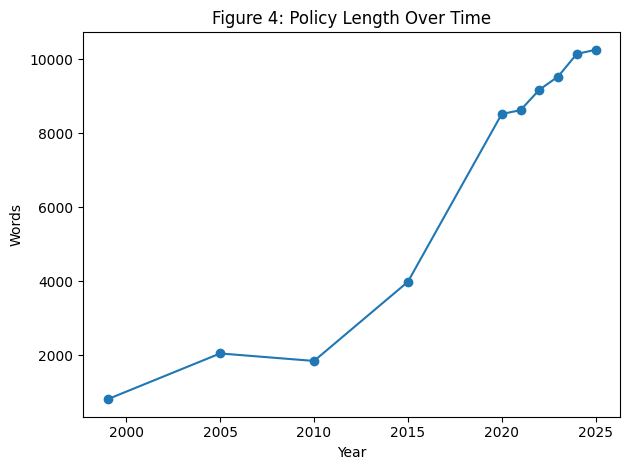

In [ ]:

plt.figure()
plt.plot(hist_df['year'], hist_df['n_words'], marker='o')
plt.xlabel('Year')
plt.ylabel('Words')
plt.title('Figure 4: Policy Length Over Time')
plt.grid(False)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'history_words.png'), dpi=200)
plt.show()

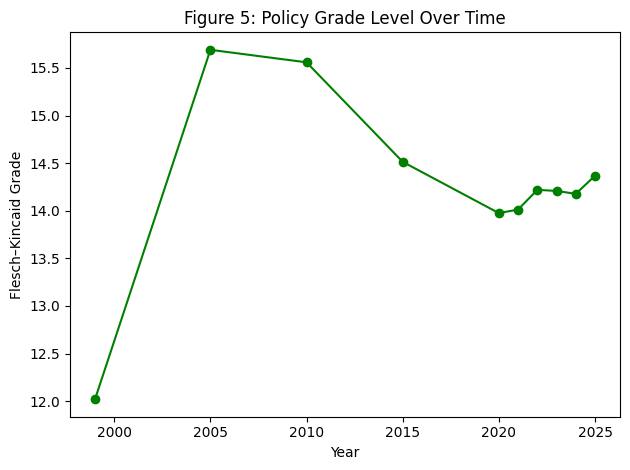

In [ ]:

plt.figure()
plt.plot(hist_df['year'], hist_df['flesch_kincaid_grade'], marker='o', color = 'g')
plt.xlabel('Year')
plt.ylabel('Flesch–Kincaid Grade')
plt.title('Figure 5: Policy Grade Level Over Time')
plt.grid(False)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'history_grade.png'), dpi=200)
plt.show()

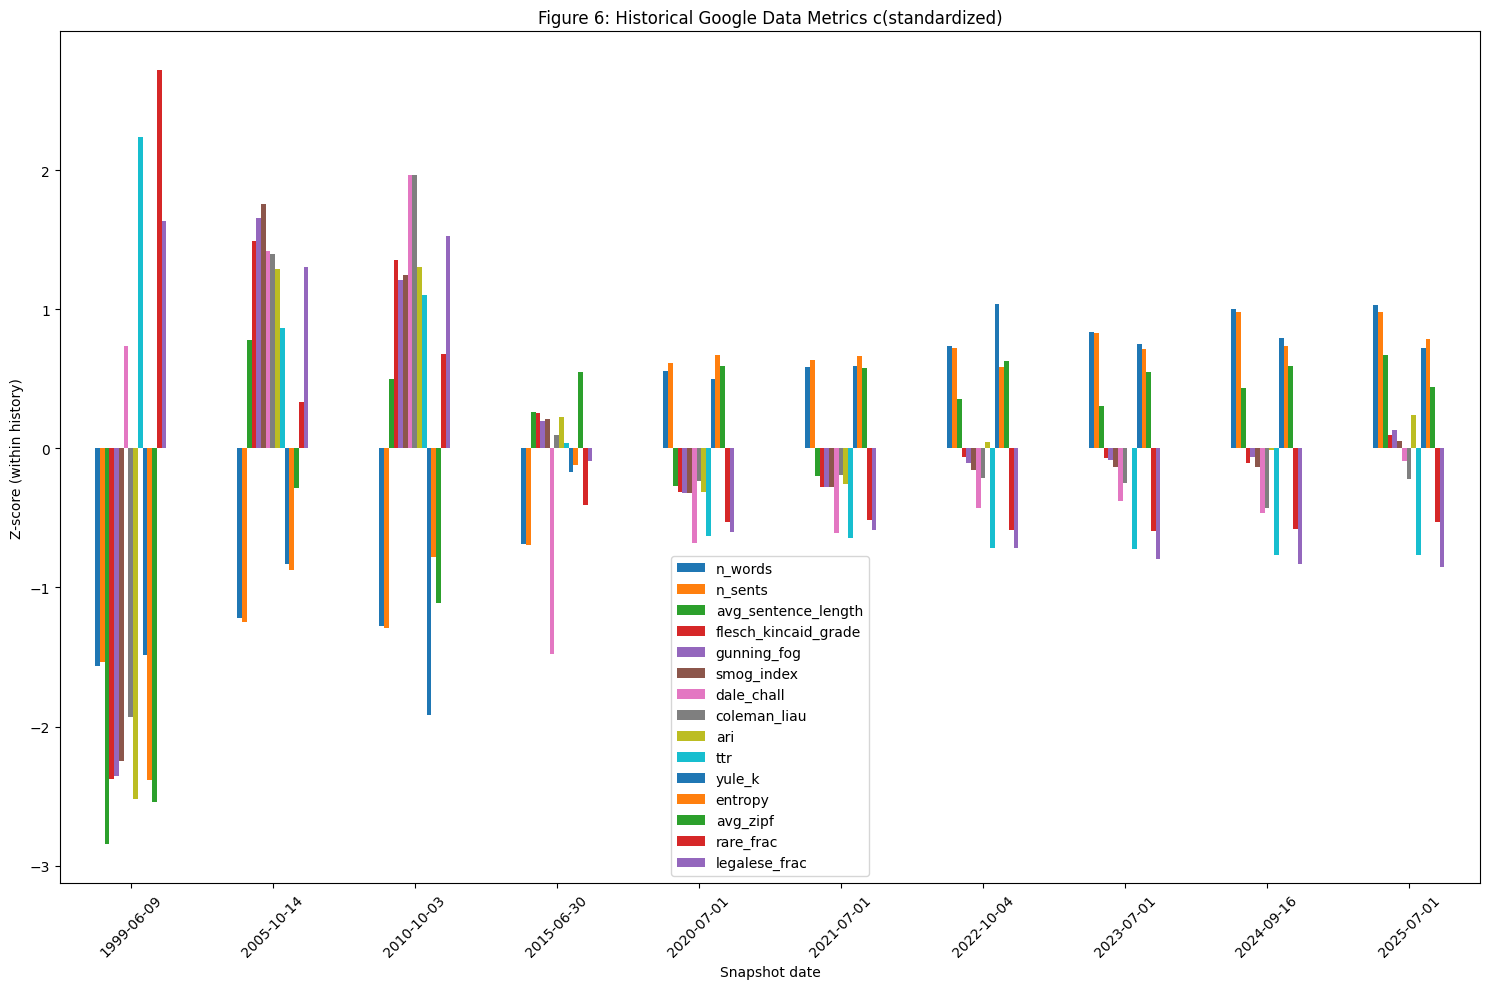

In [43]:
hist_cols = [
    'n_words','n_sents','avg_sentence_length','flesch_kincaid_grade',
    'gunning_fog','smog_index','dale_chall','coleman_liau','ari',
    'ttr','yule_k','entropy','avg_zipf','rare_frac','legalese_frac'
]
hist_cols = [c for c in hist_cols if c in hist_df.columns]

# use readable dates for the index when available
snap_idx = pd.to_datetime(hist_df.get('timestamp', pd.Series(dtype=str)), format='%Y%m%d', errors='coerce')
snap_labels = snap_idx.dt.strftime('%Y-%m-%d')
snap_labels = snap_labels.where(snap_labels.notna(), hist_df.get('date', hist_df.get('timestamp', 'snapshot')).astype(str))

H = hist_df.copy()
H.index = snap_labels

M = H[hist_cols].replace([np.inf, -np.inf], np.nan)
M = M.fillna(M.median(numeric_only=True))

Z = (M - M.mean(numeric_only=True)) / M.std(ddof=0, numeric_only=True)

fig = plt.figure(figsize=(15, 10))
ax = fig.gca()
Z.plot(kind='bar', rot=45, ax=ax)   # matplotlib backend via pandas
ax.set_xlabel('Snapshot date')
ax.set_ylabel('Z-score (within history)')
ax.set_title('Figure 6: Historical Google Data Metrics c(standardized)')
plt.tight_layout()
os.makedirs(FIG_DIR, exist_ok=True)
plt.savefig(os.path.join(FIG_DIR, 'history_metric_bars.png'), dpi=200)
plt.show()